In [1]:
#Model A - Baseline Model CNN

In [2]:
import os, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
#Path Configurations and Parameters
DATA_DIR = "C:/Users/Repti/OneDrive/Documents/GitHub/CECS456_Sem_Project/natural_images"
SPLIT_FILE = "splits.npz"
IMG_SIZE = 224
BATCH_SIZE = 32


In [8]:

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

base_ds = datasets.ImageFolder(DATA_DIR, transform=eval_tfms)
n = len(base_ds)

train_size = int(0.70 * n)
val_size   = int(0.15 * n)
test_size  = n - train_size - val_size

g = torch.Generator().manual_seed(42)
train_split, val_split, test_split = torch.utils.data.random_split(
    range(n), [train_size, val_size, test_size], generator=g
)

train_idx = np.array(train_split.indices)
val_idx   = np.array(val_split.indices)
test_idx  = np.array(test_split.indices)

np.savez(SPLIT_FILE, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)

print("Saved:", SPLIT_FILE)
print("Sizes:", len(train_idx), len(val_idx), len(test_idx))
print("Classes:", base_ds.classes)


Saved: splits.npz
Sizes: 4829 1034 1036
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [9]:
#Data Substets and Loaders
def subset_with_transform(data_dir, indices, transform):
    ds = datasets.ImageFolder(data_dir, transform=transform)
    ds.samples = [ds.samples[i] for i in indices]
    ds.targets = [ds.targets[i] for i in indices]
    return ds

train_tfms_A = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = subset_with_transform(DATA_DIR, train_idx, train_tfms_A)
val_ds   = subset_with_transform(DATA_DIR, val_idx, eval_tfms)
test_ds  = subset_with_transform(DATA_DIR, test_idx, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = base_ds.classes
num_classes = len(class_names)
num_classes, class_names


(8,
 ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person'])

In [10]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = BaselineCNN(num_classes).to(device)


In [11]:
#Training and Evaluation Functions
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    loss_fn = nn.CrossEntropyLoss()

    total_loss, total_correct, total_n = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = loss_fn(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(1).cpu().numpy()
        preds.extend(p)
        ys.extend(y.numpy())
    return np.array(ys), np.array(preds)

def plot_history(hist, title):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " - Loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " - Accuracy")
    plt.show()


C:\Users\Repti\OneDrive\Documents\GitHub\CECS456_Sem_Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train 0.7421/0.7515 | val 0.3086/0.8762
Epoch 02 | train 0.1957/0.9267 | val 0.2503/0.8994
Epoch 03 | train 0.1002/0.9598 | val 0.2864/0.9043
Epoch 04 | train 0.0410/0.9845 | val 0.4761/0.8752
Epoch 05 | train 0.0572/0.9818 | val 0.3974/0.8965
Epoch 06 | train 0.0743/0.9787 | val 0.3887/0.9091
Epoch 07 | train 0.0228/0.9938 | val 0.4055/0.9091
Epoch 08 | train 0.0409/0.9888 | val 0.4558/0.9023
Epoch 09 | train 0.0448/0.9880 | val 0.4550/0.9014
Epoch 10 | train 0.0088/0.9971 | val 0.4970/0.9091
Epoch 11 | train 0.0024/0.9994 | val 0.4629/0.9110
Epoch 12 | train 0.0101/0.9961 | val 0.7298/0.8956
Epoch 13 | train 0.0131/0.9965 | val 0.6099/0.9101
Epoch 14 | train 0.0137/0.9963 | val 0.5620/0.9159
Epoch 15 | train 0.0264/0.9928 | val 0.7701/0.8839
Epoch 16 | train 0.0135/0.9963 | val 0.6266/0.9023
Epoch 17 | train 0.0024/0.9992 | val 0.5392/0.9159
Epoch 18 | train 0.0005/0.9998 | val 0.5885/0.9120
Epoch 19 | train 0.0000/1.0000 | val 0.5847/0.9110
Epoch 20 | train 0.0000/1.0000 

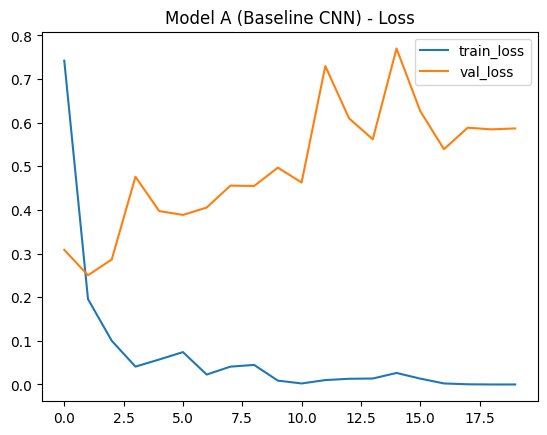

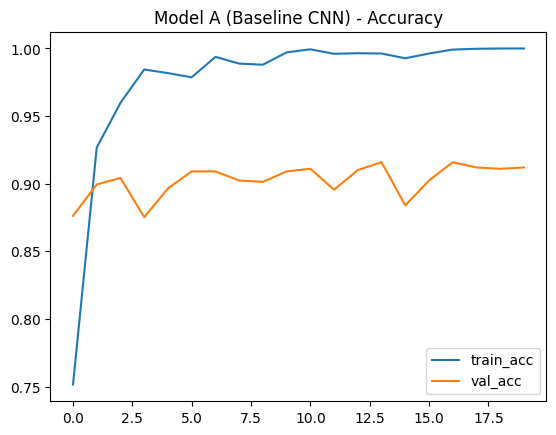

In [12]:
EPOCHS = 20
LR = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val = -1
best_state = None

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer=optimizer)
    va_loss, va_acc = run_epoch(model, val_loader, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

model.load_state_dict(best_state)
plot_history(history, "Model A (Baseline CNN)")


Model A Test Accuracy: 0.9054
Confusion Matrix:
 [[ 87   1   6   4   0   0   2   0]
 [  1 144   2   1   1   0   2   0]
 [  1   2 133  16   3   0   0   1]
 [  2   2  33  64   3   0   1   2]
 [  0   1   3   4 129   0   0   1]
 [  0   0   0   0   0 133   0   0]
 [  0   0   1   0   0   0 123   0]
 [  0   0   0   2   0   0   0 125]]

Classification Report:

              precision    recall  f1-score   support

    airplane       0.96      0.87      0.91       100
         car       0.96      0.95      0.96       151
         cat       0.75      0.85      0.80       156
         dog       0.70      0.60      0.65       107
      flower       0.95      0.93      0.94       138
       fruit       1.00      1.00      1.00       133
   motorbike       0.96      0.99      0.98       124
      person       0.97      0.98      0.98       127

    accuracy                           0.91      1036
   macro avg       0.91      0.90      0.90      1036
weighted avg       0.91      0.91      0.90      

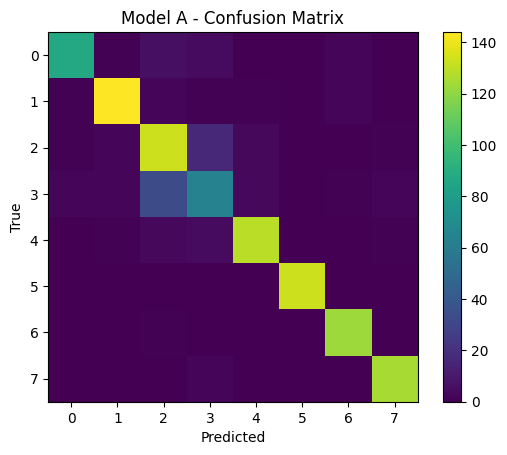

In [13]:
#Test Evaluation and Metrics
y_true, y_pred = predict_all(model, test_loader)
test_acc = (y_true == y_pred).mean()
print("Model A Test Accuracy:", round(float(test_acc), 4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure()
plt.imshow(cm)
plt.title("Model A - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()
